In [1]:
import sys; sys.path.insert(0, '..')
import dill as pickle
import numpy as np
import pandas as pd
import itertools
import dill as pickle
from ldf.best_subset import best_n_avg
from ldf.ldf import ldf
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":20})
plt.rc('legend',fontsize=16)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib inline

In [2]:
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']

In [3]:
def _calc_metrics(weights, res):
    ret_avg = (realised_returns * weights).sum(axis=0)
    res["ret"].append(ret_avg)
    wealth = [1]
    for i, r in enumerate(ret_avg):
        wealth.append(wealth[i] + wealth[i] * r)

    sharpe = (ret_avg - ir_df["USD"][-242:] / 1200).mean() / ret_avg.std()
    sharpe_ar = []
    std_ar = []
    for i in range(1, len(ret_avg)):
        sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())
        std_ar.append(ret_avg[:i].std())

    res["wealth"].append(wealth)
    res["sharpe"].append(sharpe_ar)
    res["std"].append(std_ar)
    return res
    
def get_performance(w):
    res = {"wealth": [],
           "sharpe": [],
           "std": [],
           "ret": []}
    for k in range(w.shape[0]):
        weights = w[k, -242:, :].T
        res = _calc_metrics(weights, res)
    return res

In [4]:
data_store_path = "..\\data\\FX"
ir_df = pd.read_excel(data_store_path + '\\' + "raw_data\\" + 'int' +'.xlsx', header=0, engine='openpyxl')
ir_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
ir_df["Date"] = pd.to_datetime(ir_df["Date"])

In [5]:
log_lik = np.load(r"..//data//FX//uip_l1_save_loglik.npz")["x"]

In [6]:
realised_returns = np.load(data_store_path + r"\uip_l1_save_traders.npy")

In [7]:
traders_weights = np.load(data_store_path + r"\uip_l1_save_traders_weights.npy")[:, 1:, :]

In [8]:
# longer window
realised_returns2 = np.load(data_store_path + r"\uip_l1_save_traders_return2.npy")[:, :]

In [9]:
c= 10**(-20)
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001])

# Investment based on model selection/averaging using log-scores

## $LDF_{a,a}$

In [10]:
n = 2
discount_fac = [discount_factors] * n
activation_functions = ['argmax'] * n
res_ldf = ldf(log_lik.astype(float), levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.6}")

In [11]:
portfolio_weights = np.array([(traders_weights[:, :, i] * res_ldf["weights"][3, -242:, :].T).sum(axis=0) for i in range(9)])
portfolio_weights_df = pd.DataFrame(portfolio_weights.T, index=ir_df["Date"][-242:], columns=ir_df.columns[1:-1])

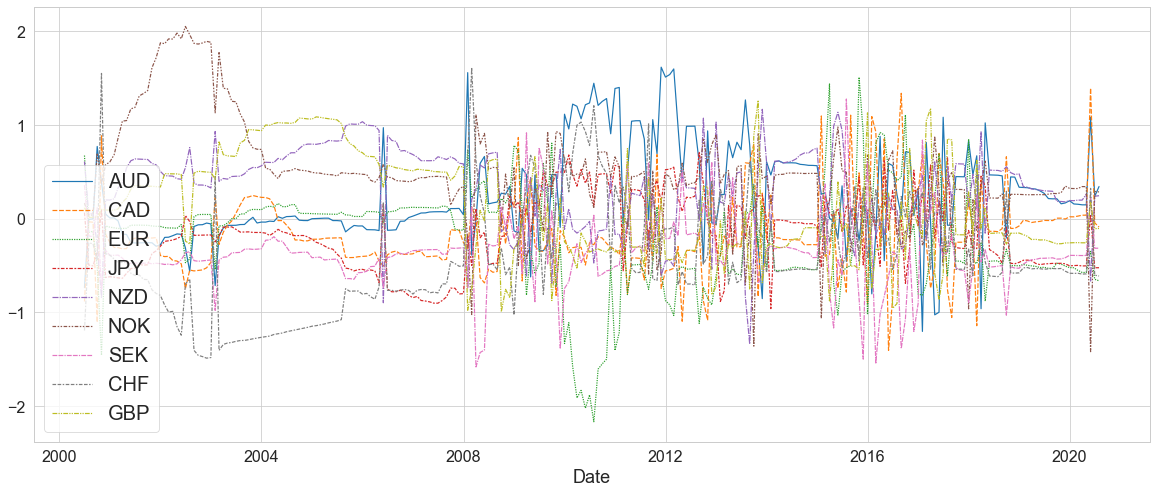

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.lineplot(data=portfolio_weights_df, ax=ax);

In [13]:
res = get_performance(res_ldf["weights"])

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


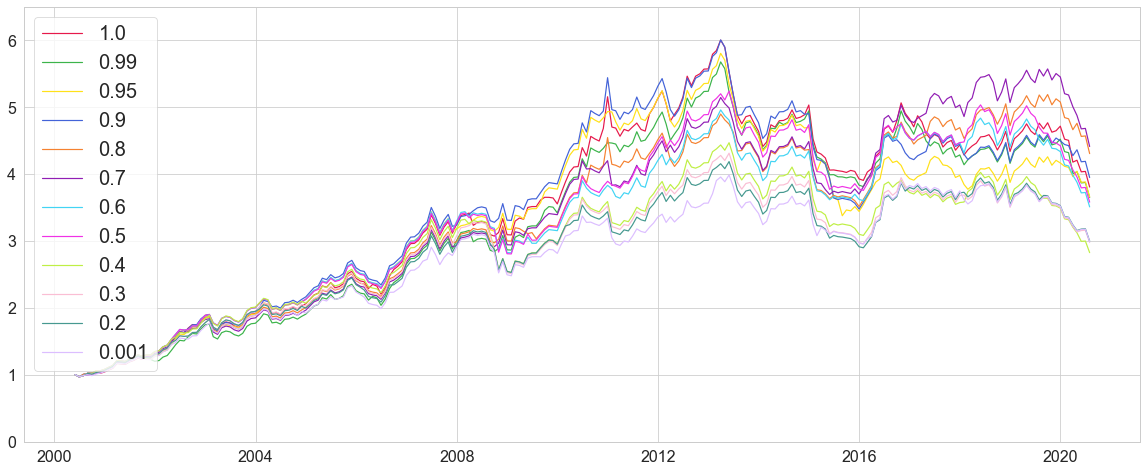

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors[k], label=discount_factors[k])
ax.set_ylim(0, 6.5)
ax.legend();

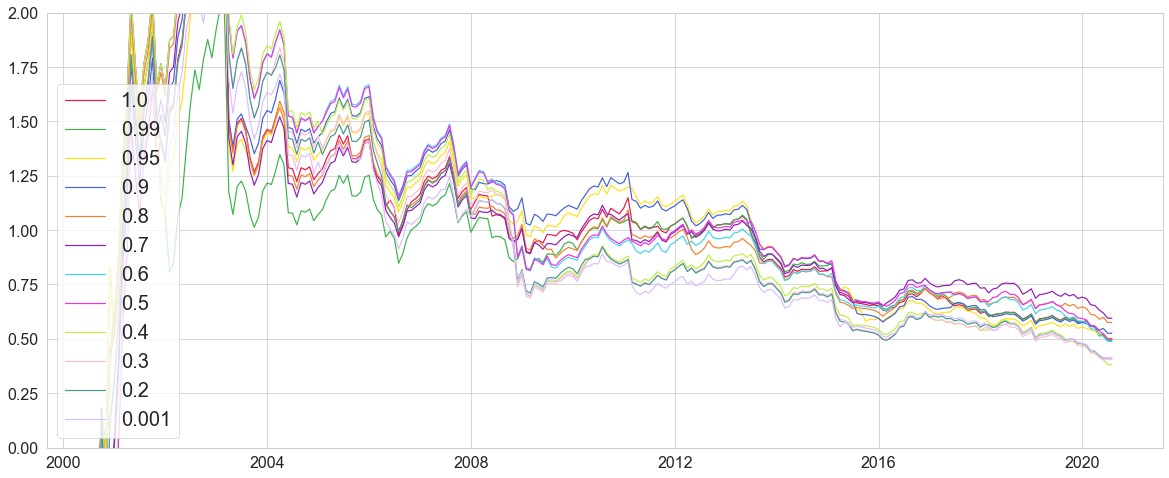

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-240:], np.asarray(res["sharpe"][k][1:]) * np.sqrt(12), c=colors[k], label=discount_factors[k])

ax.set_ylim(0,2)
ax.legend(loc="lower left");

In [16]:
pd.DataFrame([ discount_factors, np.array(res["sharpe"])[:, -1] * np.sqrt(12)])

0         1        2         3         4         5         6   \
0  1.000000  0.990000  0.95000  0.900000  0.800000  0.700000  0.600000   
1  0.498313  0.493042  0.50302  0.525136  0.574678  0.594465  0.487591   

         7         8         9         10        11  
0  0.500000  0.400000  0.300000  0.200000  0.001000  
1  0.499389  0.381362  0.404218  0.412599  0.413854

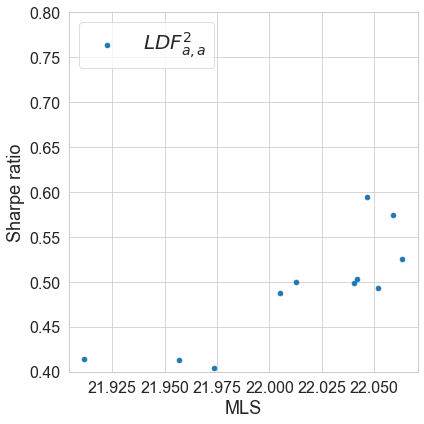

In [17]:
df_score_sharpe_aa = pd.DataFrame([ discount_factors, np.array(res["sharpe"])[:, -1] * np.sqrt(12)]).T.merge(ldfs_df, on=0).sort_values(by="1_y", ascending=False)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_score_sharpe_aa["1_y"], df_score_sharpe_aa["1_x"], label="$LDF_{a, a}^2$")
ax.set_ylim(0.4, 0.8)
ax.set_ylabel(r"Sharpe ratio")
ax.set_xlabel(r"MLS")
ax.legend(loc="upper left")
fig.tight_layout()

## $LDF_{a}$

In [18]:
res_ldf = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.6}")

In [19]:
portfolio_weights = np.array([(traders_weights[:, :, i] * res_ldf["weights"][2, -242:, :].T).sum(axis=0) for i in range(9)])
portfolio_weights_df = pd.DataFrame(portfolio_weights.T, index=ir_df["Date"][-242:], columns=ir_df.columns[1:-1])

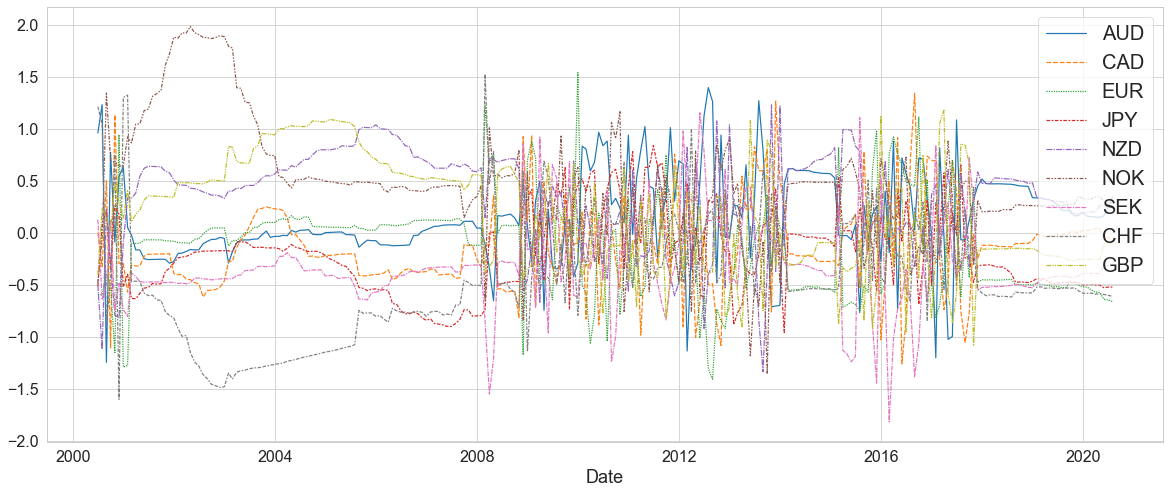

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.lineplot(data=portfolio_weights_df, ax=ax);

In [21]:
res = get_performance(res_ldf["weights"])

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


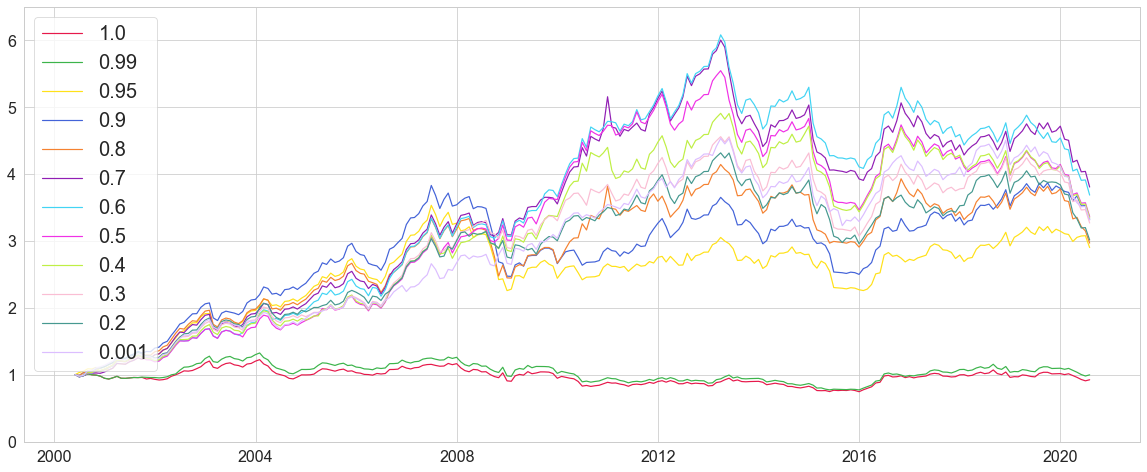

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors[k], label=discount_factors[k])
ax.set_ylim(0, 6.5)
ax.legend();

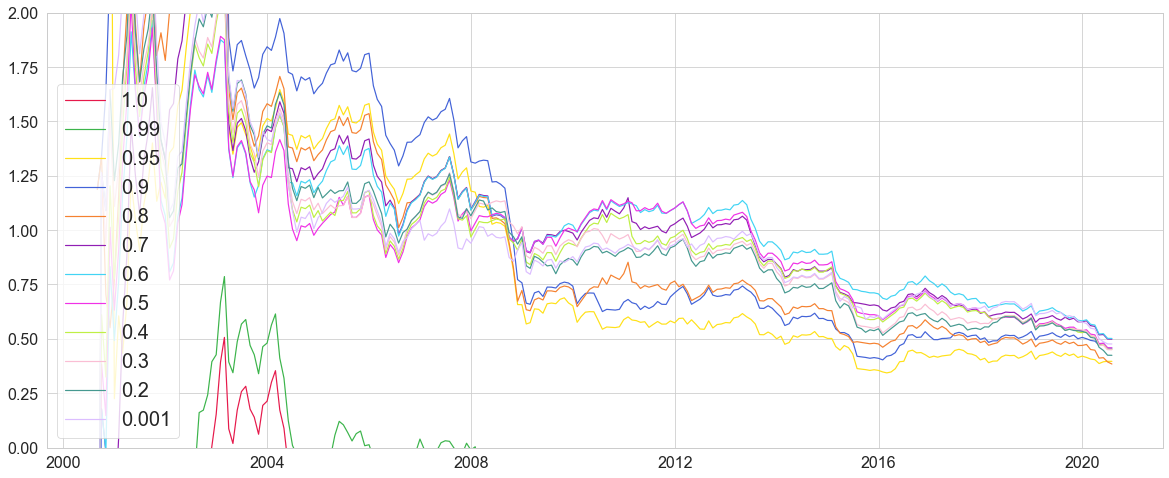

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-240:], np.asarray(res["sharpe"][k][1:]) * np.sqrt(12), c=colors[k], label=discount_factors[k])

ax.set_ylim(0,2)
ax.legend(loc="lower left");

In [24]:
pd.DataFrame([ discount_factors, np.array(res["sharpe"])[:, -1] * np.sqrt(12)])

0         1         2         3         4         5         6   \
0  1.000000  0.990000  0.950000  0.900000  0.800000  0.700000  0.600000   
1 -0.188677 -0.149738  0.396203  0.457023  0.383965  0.498313  0.501494   

         7         8         9         10        11  
0  0.500000  0.400000  0.300000  0.200000  0.001000  
1  0.458007  0.450943  0.449686  0.424063  0.476151

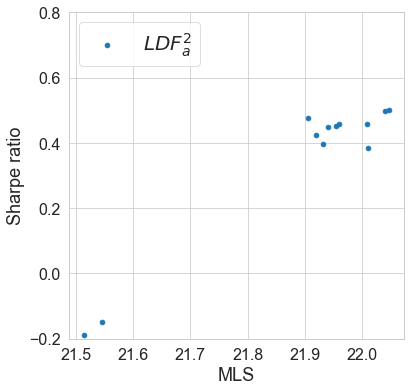

In [25]:
df_score_sharpe_a = pd.DataFrame([ discount_factors, np.array(res["sharpe"])[:, -1] * np.sqrt(12)]).T.merge(ldfs_df, on=0).sort_values(by="1_y", ascending=False)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_score_sharpe_a["1_y"], df_score_sharpe_a["1_x"], label="$LDF_{a}^2$")
ax.set_ylim(-0.2, 0.8)
ax.set_ylabel(r"Sharpe ratio")
ax.set_xlabel(r"MLS")
ax.legend(loc="upper left")

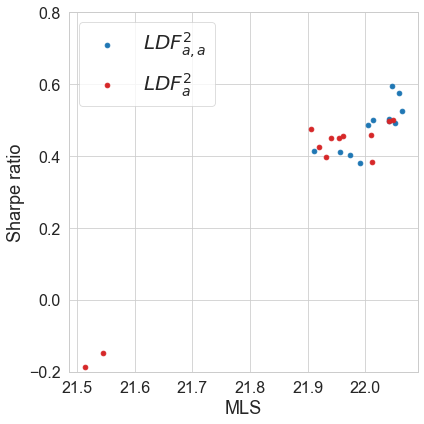

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_score_sharpe_aa["1_y"], df_score_sharpe_aa["1_x"], label="$LDF_{a, a}^2$", color='tab:blue')
ax.scatter(df_score_sharpe_a["1_y"], df_score_sharpe_a["1_x"], label="$LDF_{a}^2$", color="tab:red")
ax.set_ylim(-0.2, 0.8)
ax.set_ylabel(r"Sharpe ratio")
ax.set_xlabel(r"MLS")
ax.legend(loc="upper left")
fig.tight_layout()
plt.savefig('sharpe_mls.pdf')  

## Comapre all models based on log-scores

In [27]:
res_ldf_aa = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["argmax", "argmax"], c=c)
res_ldf_aa_arg = res_ldf_aa["logscores"][:,-242:].sum(axis=1).argmax()
res_ldf_a = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
res_ldf_a_arg = res_ldf_a["logscores"][:,-242:].sum(axis=1).argmax()

weights_comp = [
                res_ldf_aa["weights"][res_ldf_aa_arg, -242:, :].T,
                res_ldf_a["weights"][res_ldf_a_arg, -242:, :].T
                ]

In [28]:
res = {"wealth": [],
       "sharpe": [],
       "std": [],
       "ret": []}
for i in range(len(weights_comp)):
    res = _calc_metrics(weights_comp[i], res)

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


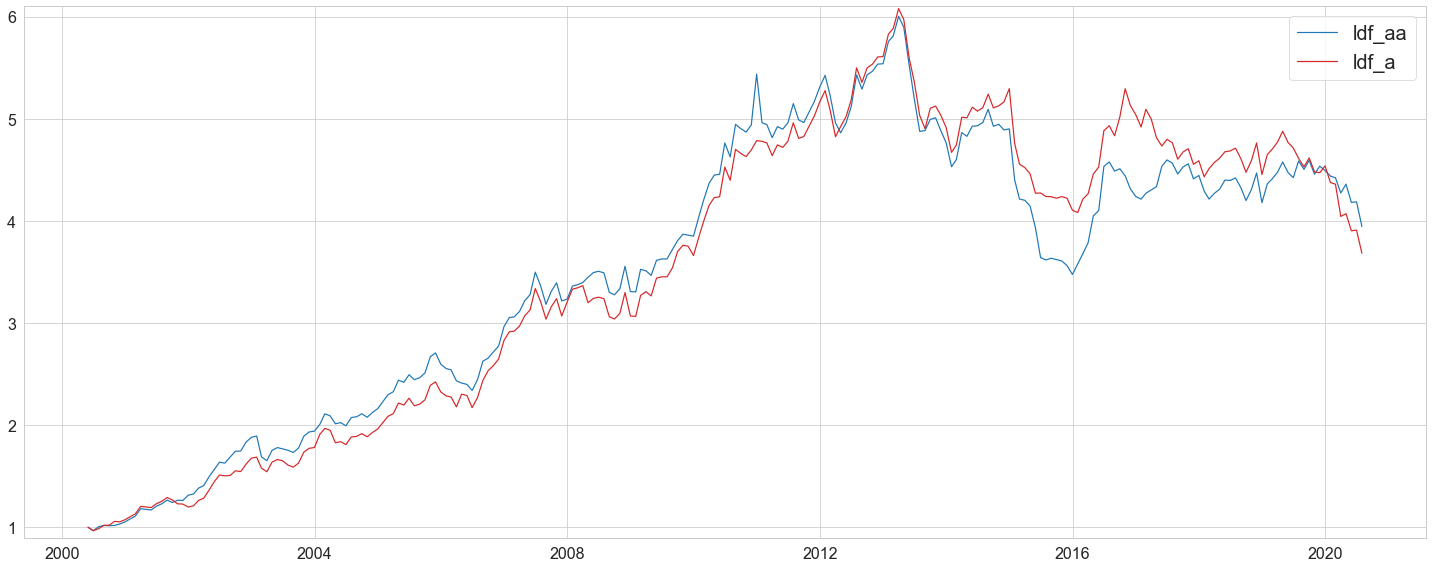

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
labels = ["ldf_aa", "ldf_a"]  # "ldf_ss", "lds_sa", "ldf_aa", "ldf_as", "lds_s", "ldf_a"
colors_small = ["tab:blue", "tab:red"]
for k in range(len(weights_comp)):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors_small[k], label=labels[k])
ax.legend();
ax.set_ylim(0.9, 6.1)
fig.tight_layout()
#plt.savefig('mls_money.pdf') 

In [30]:
pd.DataFrame([["ldf_aa", "ldf_a"], np.array(res["sharpe"])[:, -1] * np.sqrt(12)])

0         1
0    ldf_aa     ldf_a
1  0.525136  0.501494

### Analysis of the post-factum best performing models

In [31]:
res_ldf_aa = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["argmax", "argmax"], c=c)
res_ldf_aa_arg = 5

res_ldf_a = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
res_ldf_a_arg = 6

weights_comp = [res_ldf_aa["weights"][res_ldf_aa_arg, -242:, :].T,
                res_ldf_a["weights"][res_ldf_a_arg, -242:, :].T]

In [32]:
res = {"wealth": [],
       "sharpe": [],
       "std": [],
       "ret": []}
for i in range(len(weights_comp)):
    res = _calc_metrics(weights_comp[i], res)

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


In [33]:
pd.DataFrame(res["ret"]).std(axis=1) * np.sqrt(12)

0    0.109870
1    0.112638
dtype: float64

In [34]:
pd.DataFrame(res["ret"]).mean(axis=1) * np.sqrt(12)

0    0.023044
1    0.020538
dtype: float64

In [35]:
pd.DataFrame(res["ret"], index=["ldf_aa", "ldf_a"], columns=ir_df["Date"][-242:]).T[:100].mean(axis=0) * np.sqrt(12)

ldf_aa    0.038905
ldf_a     0.040556
dtype: float64

In [36]:
pd.DataFrame(res["ret"]).median(axis=1) * np.sqrt(12)

0    0.025912
1    0.023341
dtype: float64

<AxesSubplot: xlabel='Date'>

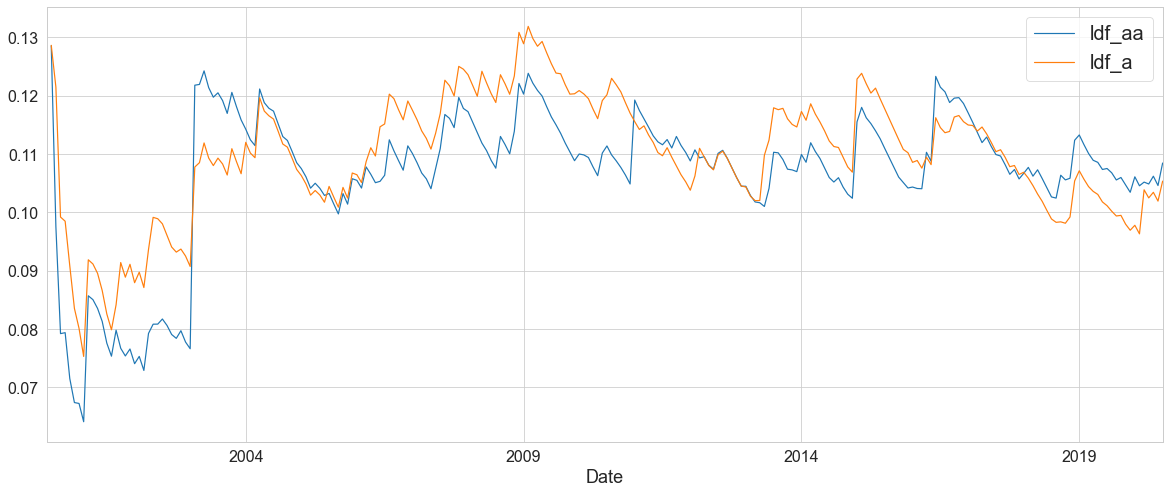

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
(pd.DataFrame(res["ret"], index=["ldf_aa", "ldf_a"], columns=ir_df["Date"][-242:]).T.ewm(alpha=0.03).std() * np.sqrt(12)).plot(ax=ax)

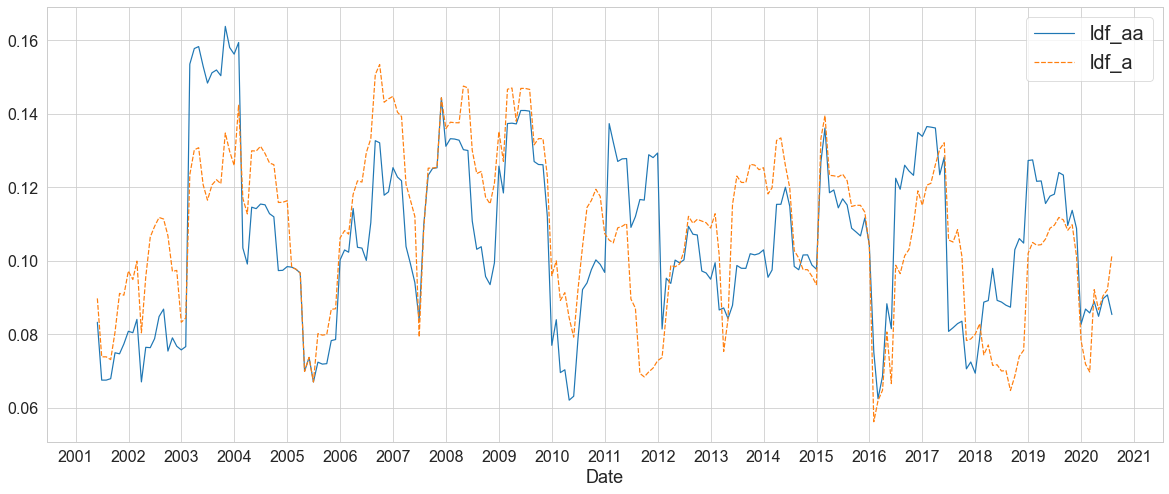

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.lineplot(data=(pd.DataFrame(res["ret"], index=["ldf_aa", "ldf_a"], columns=ir_df["Date"][-242:]).T.rolling(12).std() * np.sqrt(12)), ax=ax)
yloc = YearLocator()
ax.xaxis.set_major_locator(yloc)

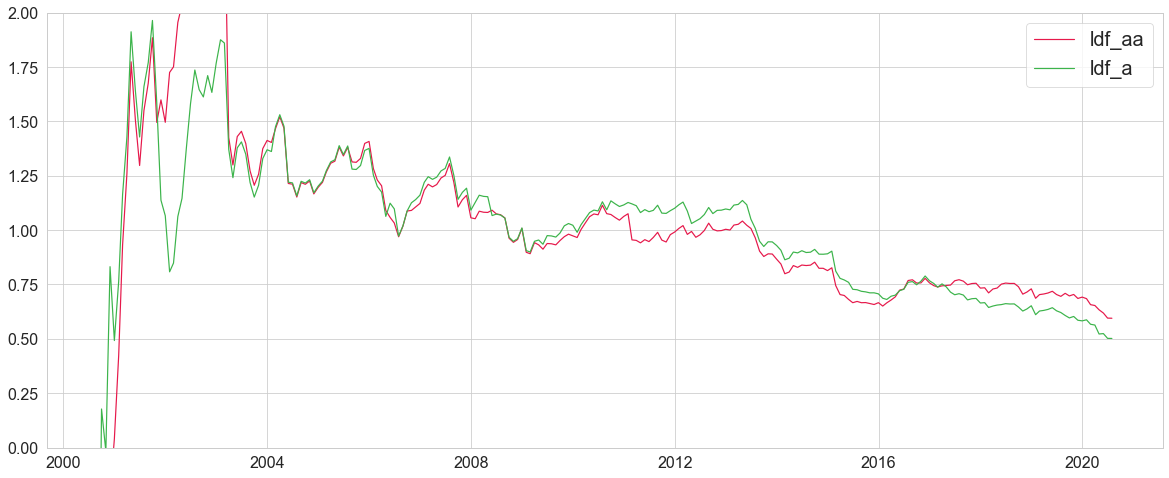

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
labels = ["ldf_aa", "ldf_a"]
for k in range(len(weights_comp)):
    ax.plot(ir_df["Date"][-240:], np.sqrt(12) * np.array(res["sharpe"][k][1:]), c=colors[k], label=labels[k])

ax.set_ylim(0,2)    
ax.legend();

# Investment based on model selection/averaging using focused scores

### Focused score based on Sharpe ratio. Want to maximise risk adjusted returns. Divide traders' returns by the ... volatility of the strategy

In [40]:
lam = 1
window = 12
risk_adj_ret = (pd.DataFrame(realised_returns2.T) / pd.DataFrame(realised_returns2.T).rolling(window,window).std()).to_numpy().T[:, window:]
risk_adj_ret = risk_adj_ret / lam

## $LDF_{a,a}$

In [41]:
n = 2
discount_fac = [discount_factors] * n
activation_functions = ['argmax'] * n
res_ldf = ldf(risk_adj_ret.astype(float), levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.6}")

In [42]:
discount_factors[res_ldf["logscores"][:,:-242].sum(axis=1).argmax()]

0.95

In [43]:
discount_factors[res_ldf["logscores"][:,-242:].sum(axis=1).argmax()]

0.7

In [44]:
portfolio_weights = np.array([(traders_weights[:, :, i] * res_ldf["weights"][5, -242:, :].T).sum(axis=0) for i in range(9)])
portfolio_weights_df = pd.DataFrame(portfolio_weights.T, index=ir_df["Date"][-242:], columns=ir_df.columns[1:-1])

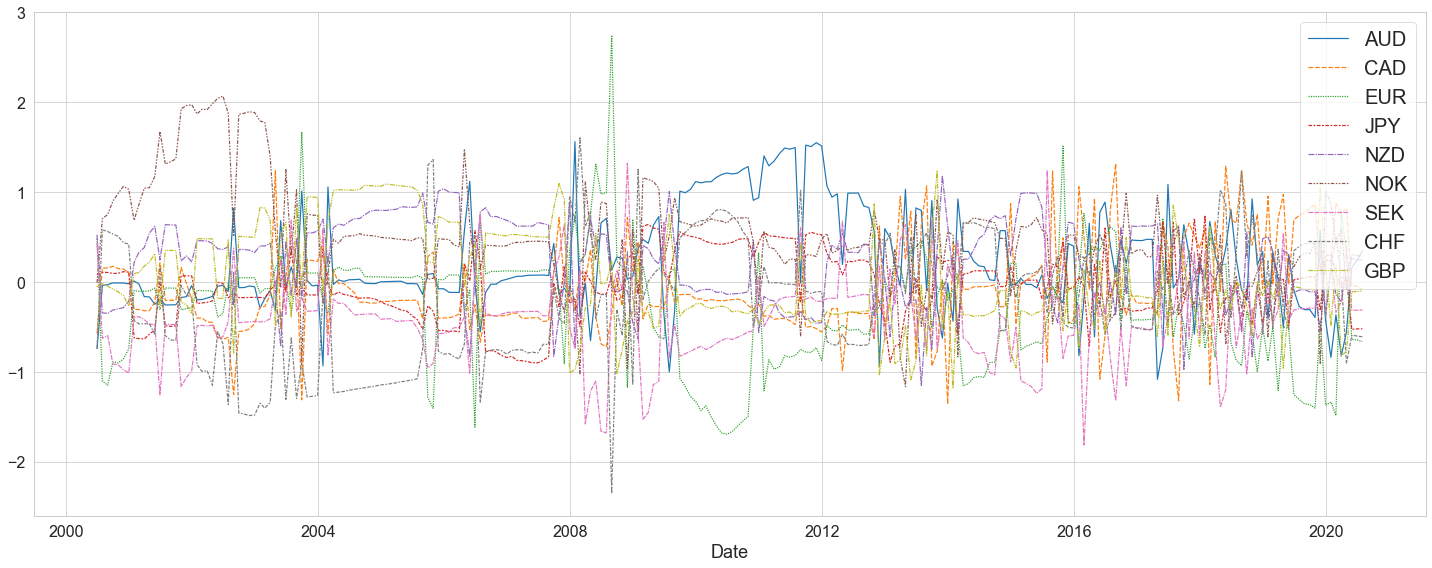

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.lineplot(data=portfolio_weights_df, ax=ax);
fig.tight_layout()
#plt.savefig('ldfaa_focused_portfolio.pdf') 

In [46]:
res = get_performance(res_ldf["weights"])

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


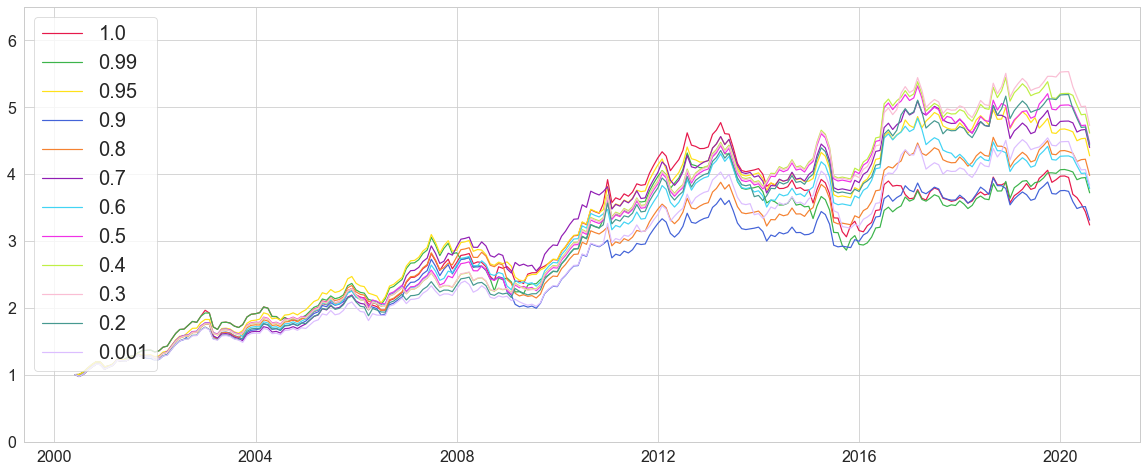

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors[k], label=discount_factors[k])
ax.set_ylim(0, 6.5)
ax.legend();

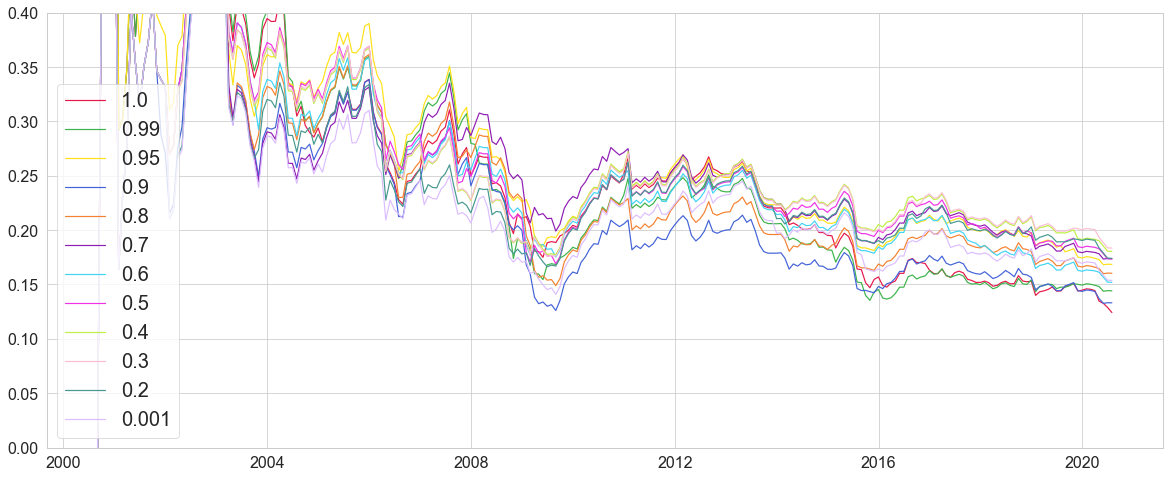

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-240:], res["sharpe"][k][1:], c=colors[k], label=discount_factors[k])

ax.set_ylim(0,0.4)
ax.legend(loc="lower left");

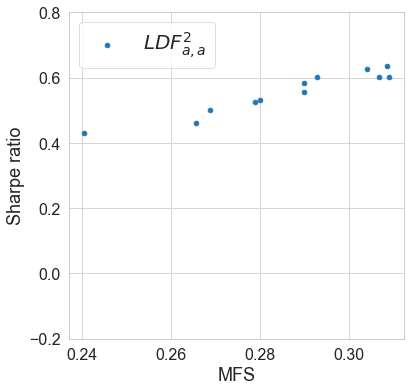

In [49]:
df_score_sharpe_aa = pd.DataFrame([ discount_factors, np.array(res["sharpe"])[:, -1] * np.sqrt(12)]).T.merge(ldfs_df, on=0).sort_values(by="1_y", ascending=False)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_score_sharpe_aa["1_y"], df_score_sharpe_aa["1_x"], label="$LDF_{a, a}^2$")
ax.set_ylim(-0.2, 0.8)
ax.set_ylabel(r"Sharpe ratio")
ax.set_xlabel(r"MFS")
ax.legend(loc="upper left")

In [50]:
df_score_sharpe_aa

0       1_x       1_y          2
5   0.700  0.601706  0.308839  74.738928
9   0.300  0.635458  0.308386  74.629453
7   0.500  0.600322  0.306616  74.201019
8   0.400  0.624751  0.303950  73.555946
10  0.200  0.602684  0.292693  70.831799
2   0.950  0.583370  0.289858  70.145692
4   0.800  0.555136  0.289834  70.139787
11  0.001  0.532459  0.280044  67.770722
6   0.600  0.526364  0.278951  67.506248
1   0.990  0.499238  0.268718  65.029707
3   0.900  0.460927  0.265687  64.296246
0   1.000  0.430062  0.240591  58.222963

## $LDF_{a}$

In [51]:
res_ldf = ldf(risk_adj_ret.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.6}")

In [52]:
portfolio_weights = np.array([(traders_weights[:, :, i] * res_ldf["weights"][3, -242:, :].T).sum(axis=0) for i in range(9)])
portfolio_weights_df = pd.DataFrame(portfolio_weights.T, index=ir_df["Date"][-242:], columns=ir_df.columns[1:-1])

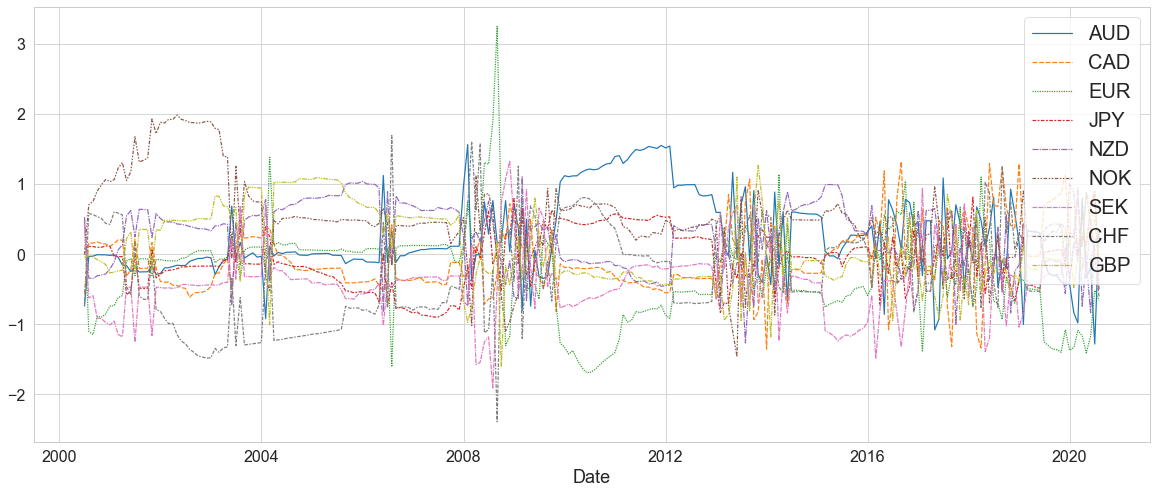

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sns.lineplot(data=portfolio_weights_df, ax=ax);

In [54]:
res = get_performance(res_ldf["weights"])

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


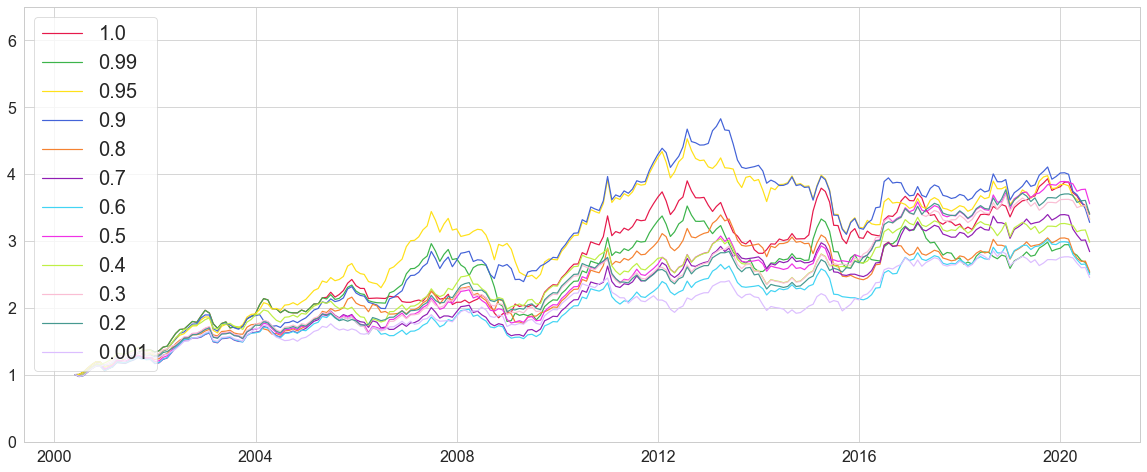

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
for k in range(res_ldf["weights"].shape[0]):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors[k], label=discount_factors[k])
ax.set_ylim(0, 6.5)
ax.legend();

In [56]:
pd.DataFrame(np.array([ discount_factors, np.array(res["sharpe"])[:, -1]]) * np.sqrt(12))

0         1         2         3         4         5         6   \
0  3.464102  3.429461  3.290897  3.117691  2.771281  2.424871  2.078461   
1  0.451693  0.311661  0.439872  0.437103  0.338350  0.396912  0.336844   

         7         8         9         10        11  
0  1.732051  1.385641  1.039230  0.692820  0.003464  
1  0.511911  0.440273  0.505756  0.528564  0.354752

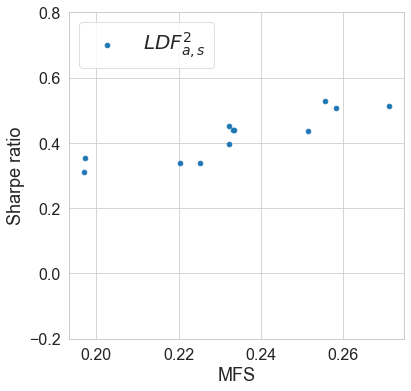

In [57]:
df_score_sharpe_a = pd.DataFrame([ discount_factors, np.array(res["sharpe"])[:, -1] * np.sqrt(12)]).T.merge(ldfs_df, on=0).sort_values(by="1_y", ascending=False)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_score_sharpe_a["1_y"], df_score_sharpe_a["1_x"], label="$LDF_{a, s}^2$")
ax.set_ylim(-0.2, 0.8)
ax.set_ylabel(r"Sharpe ratio")
ax.set_xlabel(r"MFS")
ax.legend(loc="upper left")

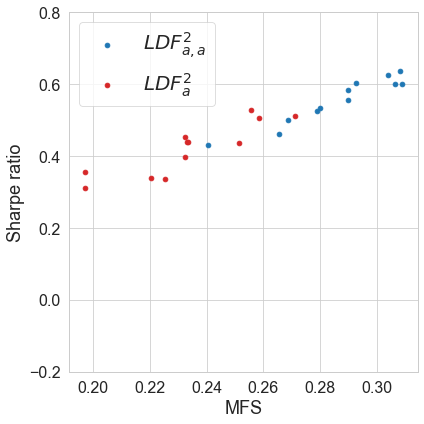

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_score_sharpe_aa["1_y"], df_score_sharpe_aa["1_x"], label="$LDF_{a, a}^2$", color='tab:blue')
ax.scatter(df_score_sharpe_a["1_y"], df_score_sharpe_a["1_x"], label="$LDF_{a}^2$", color="tab:red")
ax.set_ylim(-0.2, 0.8)
ax.set_ylabel(r"Sharpe ratio")
ax.set_xlabel(r"MFS")
ax.legend(loc="upper left")
fig.tight_layout()
plt.savefig('sharpe_mfs.pdf') 

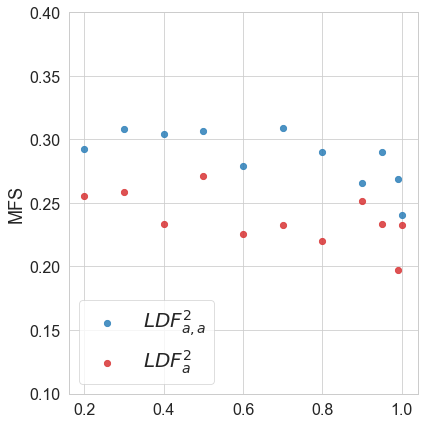

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(df_score_sharpe_aa.sort_values(0, ascending=False)[0].to_list()[:-1], df_score_sharpe_aa.sort_values(0, ascending=False)["1_y"].to_list()[:-1], marker='o', color='tab:blue', label="$LDF_{a, a}^2$", s=40, alpha=0.8)
ax.scatter(df_score_sharpe_a.sort_values(0, ascending=False)[0].to_list()[:-1], df_score_sharpe_a.sort_values(0, ascending=False)["1_y"].to_list()[:-1], marker='o', color='tab:red', label="$LDF_{a}^2$", s=40, alpha=0.8)
ax.set_ylabel(r"MFS")
ax.set_ylim(0.1, 0.4)
ax.legend(loc="lower left");
fig.tight_layout()
plt.savefig('mfs_delta.pdf') 

## Compare all models based on focused scores

In [60]:
res_ldf_aa = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["argmax", "argmax"], c=c)
res_ldf_aa_arg = res_ldf_aa["logscores"][:,-242:].sum(axis=1).argmax()
res_ldf_a = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
res_ldf_a_arg = res_ldf_a["logscores"][:,-242:].sum(axis=1).argmax()

weights_comp_log = [res_ldf_aa["weights"][res_ldf_aa_arg, -242:, :].T,
                    res_ldf_a["weights"][res_ldf_a_arg, -242:, :].T]

In [61]:
res_ldf_aa = ldf(risk_adj_ret.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["argmax", "argmax"], c=c)
res_ldf_aa_arg = res_ldf_aa["logscores"][:,-242:].sum(axis=1).argmax()

res_ldf_a = ldf(risk_adj_ret.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
res_ldf_a_arg = res_ldf_a["logscores"][:,-242:].sum(axis=1).argmax()

weights_comp = [
                res_ldf_aa["weights"][res_ldf_aa_arg, -242:, :].T,
                res_ldf_aa["weights"][0, -242:, :].T,
                res_ldf_a["weights"][res_ldf_a_arg, -242:, :].T
                ]

In [62]:
res_log = {"wealth": [],
       "sharpe": [],
       "ret": [],
       "std": []}
for i in range(len(weights_comp_log)):
    res_log = _calc_metrics(weights_comp_log[i], res_log)

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


In [63]:
res = {"wealth": [],
       "sharpe": [],
       "ret": [],
       "std": []}
for i in range(len(weights_comp)):
    res = _calc_metrics(weights_comp[i], res)

C:\Users\BEARBU~1\AppData\Local\Temp/ipykernel_20924/2224238442.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  sharpe_ar.append((ret_avg[:i] - ir_df["USD"][-242:(-242+i)] / 1200).mean() / ret_avg[:i].std())


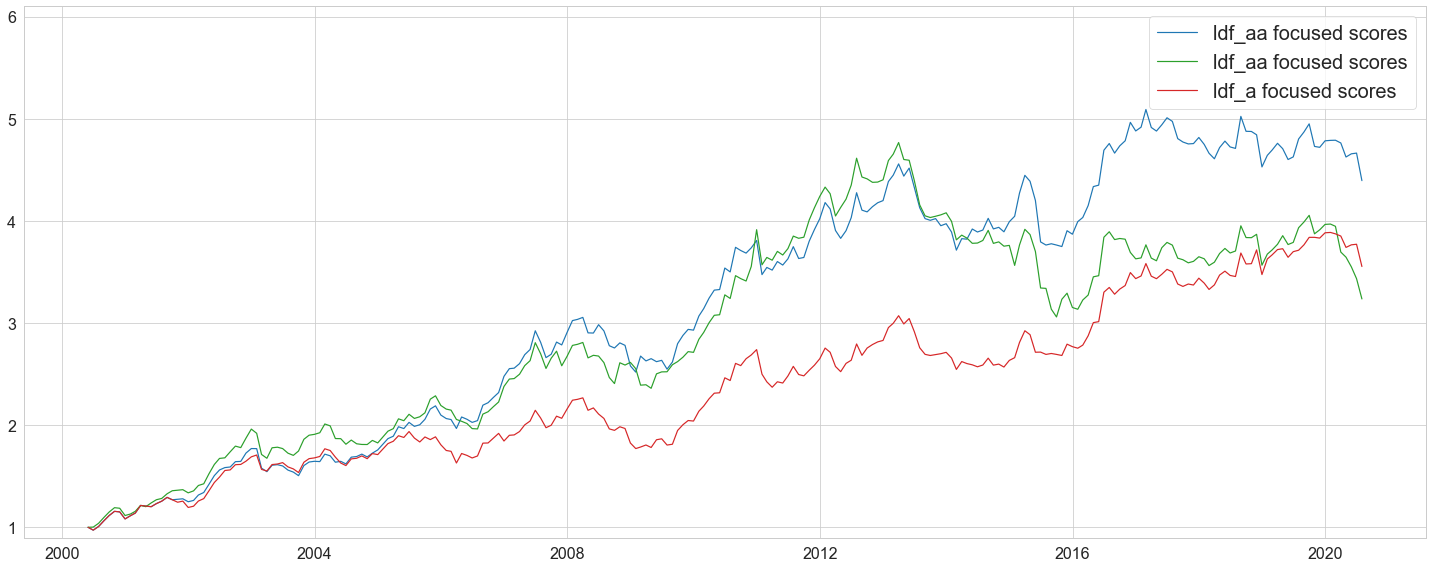

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
labels = ["ldf_aa", "ldf_aa", "ldf_a"]  # "ldf_ss", "lds_sa", "ldf_aa", "ldf_as", "lds_s", "ldf_a"
colors_small = ["tab:blue", "tab:green", "tab:red"]
for k in range(len(weights_comp)):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors_small[k], label=labels[k] + " focused scores")
    
ax.legend();
ax.set_ylim(0.9, 6.1)
fig.tight_layout()
#plt.savefig('money.pdf') 

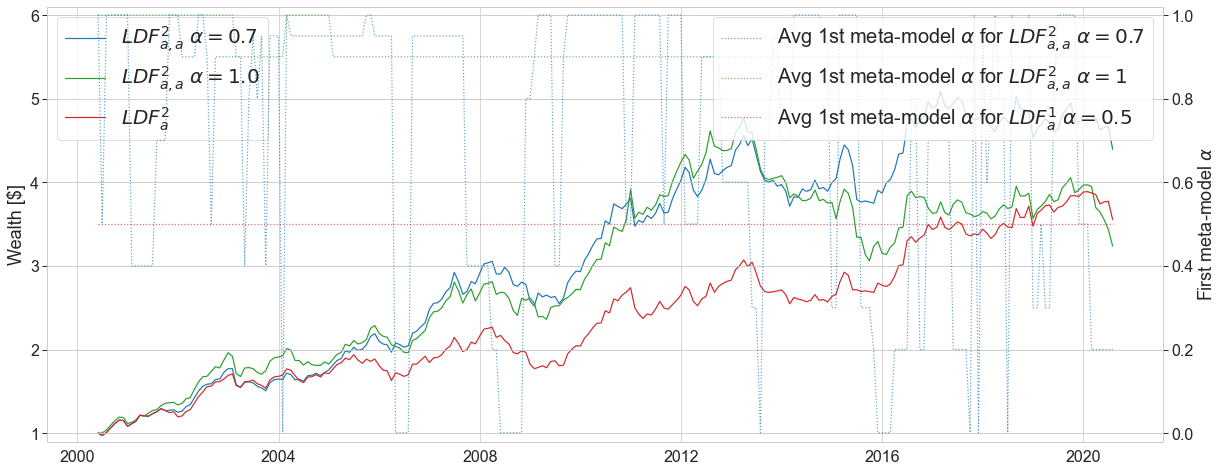

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
labels = ["$LDF_{a, a}^2$ $α=0.7$", "$LDF_{a, a}^2$ $α=1.0$","$LDF_{a}^2$"] 
colors_small = ["tab:blue", "tab:green", "tab:red"]
for k in range(len(weights_comp)):
    ax.plot(ir_df["Date"][-243:], res["wealth"][k], c=colors_small[k], label=labels[k])

_temp = res_ldf_aa["params_weights"][res_ldf_aa_arg] * discount_factors
d_factors = (_temp)[np.nonzero(_temp)]    
ax2 = ax.twinx()
lns2 = ax2.plot(ir_df["Date"][-243:], d_factors[-243:], c="tab:blue", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{a, a}^2$ $\alpha=0.7$', linestyle="dotted")
_temp = res_ldf_aa["params_weights"][0] * discount_factors
d_factors = (_temp)[np.nonzero(_temp)] 
lns2 = ax2.plot(ir_df["Date"][-243:], d_factors[-243:], c="tab:green", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{a, a}^2$ $\alpha=1$', linestyle="dotted")
lns2 = ax2.plot(ir_df["Date"][-243:], [0.5]*243, c="tab:red", alpha=0.7, label=r'Avg 1st meta-model $\alpha$ for $LDF_{a}^1$ $\alpha=0.5$', linestyle="dotted")
ax2.set_ylim(-0.02, 1.02)
ax2.legend(loc="upper right");
ax2.set_ylabel(r"First meta-model " + r"$\alpha$")
# for k in range(len(weights_comp_log)):
#     ax.plot(ir_df["Date"][-243:], res_log["wealth"][k], c=colors_small[k], label=labels[k] + " log scores", linestyle="--")
ax.legend(loc="upper left");
ax.set_ylim(0.9, 6.1)
ax.set_ylabel("Wealth [$]")
#fig.tight_layout()
plt.savefig('money_focused.pdf') 

In [66]:
_temp = res_ldf_aa["params_weights"][res_ldf_aa_arg] * discount_factors
_temp.sum(axis=1).mean()

0.7139598853868195

In [67]:
_temp = res_ldf_aa["params_weights"][0] * discount_factors
_temp.sum(axis=1).mean()

0.8040114613180518